In [2]:
import pandas as pd
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt
import itertools
import warnings
import statsmodels.api as sm
import statsmodels
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

Let's see the data:

In [3]:
df2 = pd.read_pickle("dfmaxcel.pkl")

In [10]:
df2 = df2.rename(columns ={"DateMax": "timeMax"})
df2.index.names = ["time"]

In [23]:
df2 = df2.dropna()

In [24]:
df2

,timeMax
time,
1858-01-01,14.444444
1858-01-03,13.333333
1858-01-04,8.333333
1858-01-05,13.888889
1858-01-06,15.555556
...,...
2020-12-27,25.611111
2020-12-28,26.111111
2020-12-29,26.111111


In [25]:
plt.figure(figsize=(16,10), dpi=100)
plt.plot(df2.index, df2.timeMax, color='tab:red')
plt.gca().set(title="Max temp montlhy, USA 1947-2021", xlabel='Date', ylabel="Degree (in Celsius)")
plt.show()

KeyboardInterrupt: 

<AxesSubplot:xlabel='time'>

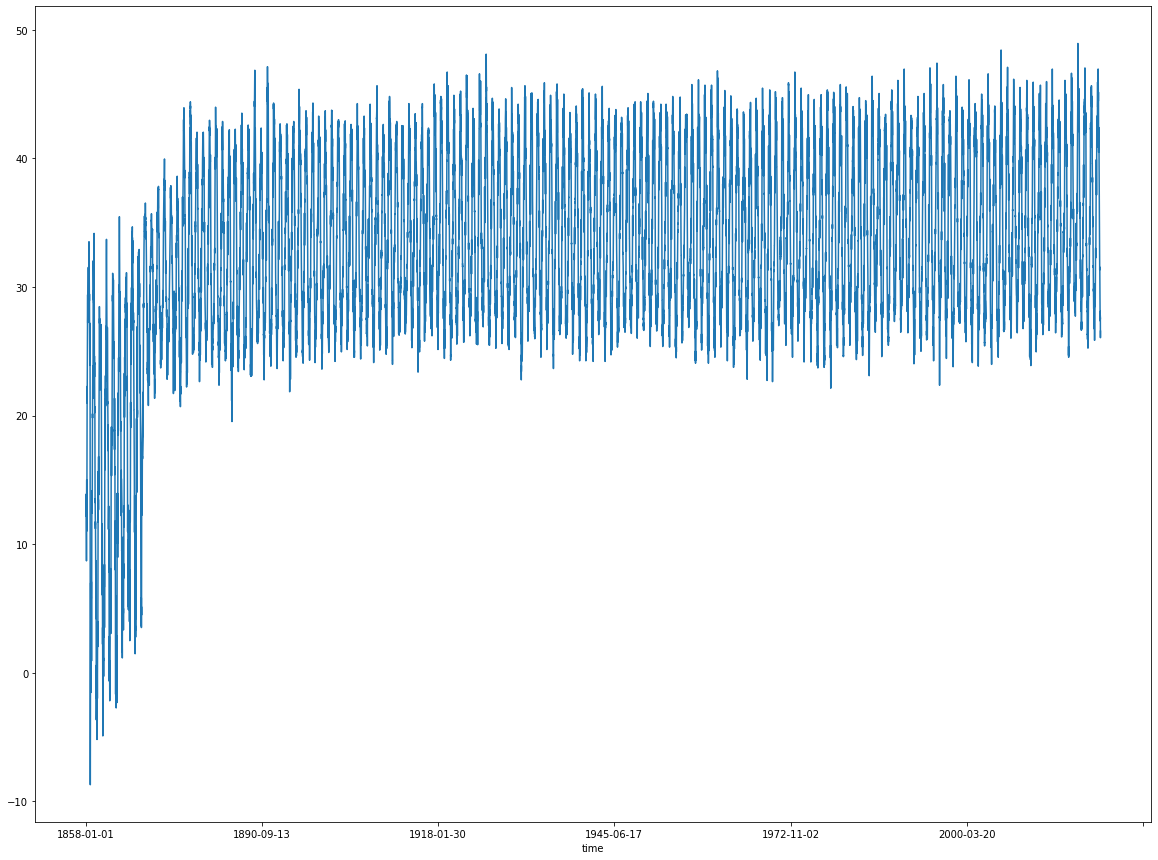

In [26]:
# Apply the Moving Average function by a subset of size 12 months to timeMax.
temp_df_mean = df2.timeMax.rolling(window=12).mean()
temp_df_mean.plot(figsize=(20,15))

Seasonal decomposition: (12 months)

In [ ]:
#FOR time MAX
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive Decomposition
result_add = seasonal_decompose(df2.timeMax, model='additive', extrapolate_trend='freq', freq=365)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decomposition', fontsize=22)
plt.show()

<ipython-input-27-ae46d449d687>:5: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result_add = seasonal_decompose(df2.timeMax, model='additive', extrapolate_trend='freq', freq=365)


<ipython-input-21-91af9d98f550>:5: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result_add = seasonal_decompose(df2.timeMin, model='additive', extrapolate_trend='freq', freq=60)


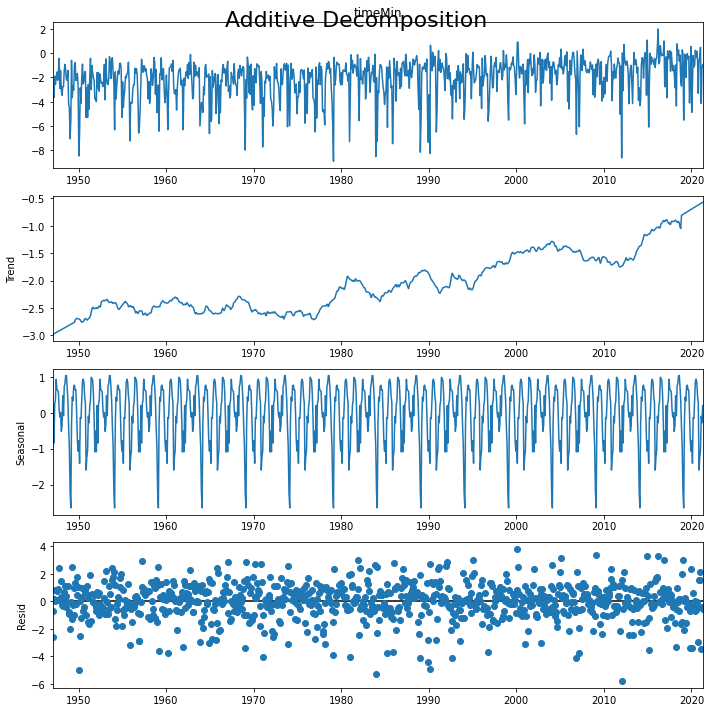

In [21]:
#FOR time MIN
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive Decomposition
result_add = seasonal_decompose(df2.timeMin, model='additive', extrapolate_trend='freq', freq=60)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decomposition', fontsize=22)
plt.show()

In [3]:
dfMax = df2.drop(["timeMin"], axis =1)
dfMin = df2.drop(["timeMax"], axis =1)

The stationarity of both the timeseries is ok: so we cak fit a sarimax

In [28]:
result =adfuller(dfMax)

print('ADF statistics: %f' % result[0])
print('pvalue: %f' % result[1])
print('Critical values:')
for key,value in result[4].items():
    print('\t%s: %.3f' % (key,value))

ADF statistics: -3.701988
pvalue: 0.004085
Critical values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


In [34]:
result =adfuller(dfMin)

print('ADF statistics: %f' % result[0])
print('pvalue: %f' % result[1])
print('Critical values:')
for key,value in result[4].items():
    print('\t%s: %.3f' % (key,value))

ADF statistics: -4.058580
pvalue: 0.001133
Critical values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


Autocorellation and Partial autocorellations suggest a seosonality of 12 months for both

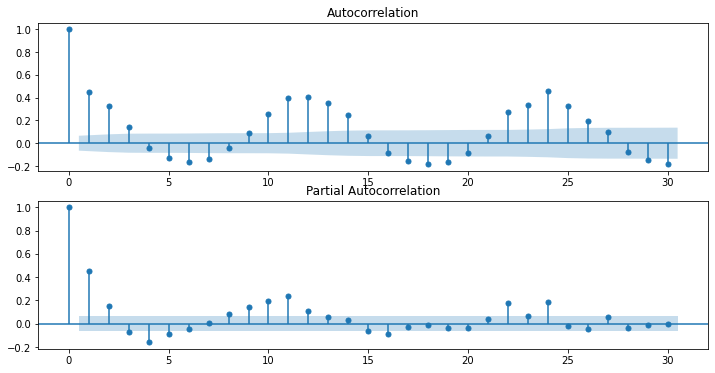

In [35]:
fig,ax = plt.subplots(2, figsize=(12,6))
ax[0]= plot_acf(dfMax, ax=ax[0],lags=30)
ax[1]= plot_pacf(dfMax, ax=ax[1],lags=30)

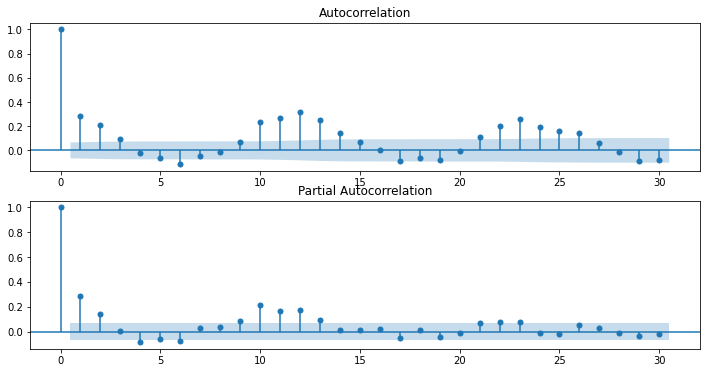

In [36]:
fig,ax = plt.subplots(2, figsize=(12,6))
ax[0]= plot_acf(dfMin, ax=ax[0],lags=30)
ax[1]= plot_pacf(dfMin, ax=ax[1],lags=30)

------------------------------------------------------------------------------------------------------------FIRST MODEL---------------------------------------------------------------------------------------------------------------------

--------------------HERE only on dfMAX, then when we pick the best ----------------------------approach we'll do also for dfMin (it will be the same)----------

NO TEST AND TRAINING DATA: https://github.com/imkhoa99/Time-Series-Analysis-and-Weather-Forecast-/blob/master/Time_Series_Project.ipynb

The sarima model. First search for the best AIC then train the model

In [37]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [38]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages
metric_aic_dict = dict()
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(dfMax,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            metric_aic_dict.update({(param,param_seasonal):results.aic})
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:4815.725578853234
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:4308.101712529504
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:3799.303930842286
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:3234.3258859222888
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:3728.149827891877
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:3267.4640207981
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:3443.5224552348036
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3242.6015831453906
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:4293.779109693448
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:4037.351393410512
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:3784.5842035486585
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:3208.814394725795
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:3699.026818149423
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:3244.4161010798616
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:3418.119897160982
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:3215.885871227505
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:3769.0603028489677
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:3718.9

In [50]:
{k: v for k, v in sorted(metric_aic_dict.items(),key=lambda x:x[1])}

{((1, 1, 1), (0, 1, 1, 12)): 3176.7977630048667,
 ((1, 0, 1), (0, 1, 1, 12)): 3177.69652883496,
 ((1, 1, 1), (1, 1, 1, 12)): 3178.7973699204426,
 ((1, 0, 1), (1, 1, 1, 12)): 3185.7360440486973,
 ((0, 1, 1), (0, 1, 1, 12)): 3188.395887047608,
 ((0, 1, 1), (1, 1, 1, 12)): 3200.207121649293,
 ((1, 0, 0), (0, 1, 1, 12)): 3204.6097778593967,
 ((0, 0, 1), (0, 1, 1, 12)): 3208.814394725795,
 ((1, 0, 0), (1, 1, 1, 12)): 3213.138387593151,
 ((0, 0, 1), (1, 1, 1, 12)): 3215.885871227505,
 ((1, 0, 1), (1, 0, 1, 12)): 3218.88216960999,
 ((1, 1, 1), (1, 0, 1, 12)): 3233.3727364383735,
 ((0, 0, 0), (0, 1, 1, 12)): 3234.3258859222888,
 ((1, 0, 0), (1, 0, 1, 12)): 3240.5963184967068,
 ((0, 0, 0), (1, 1, 1, 12)): 3242.6015831453906,
 ((0, 1, 1), (1, 0, 1, 12)): 3243.6159205130834,
 ((0, 0, 1), (1, 0, 1, 12)): 3244.4161010798616,
 ((0, 0, 0), (1, 0, 1, 12)): 3267.4640207981,
 ((1, 1, 1), (1, 0, 0, 12)): 3393.453252205206,
 ((1, 0, 1), (1, 1, 0, 12)): 3395.5907264381663,
 ((1, 1, 0), (0, 1, 1, 12)): 3395

In [52]:
# Fit the SARIMAX model using optimal parameters i.e First line
#{((1, 1, 1), (0, 1, 1, 12)): 3176.7977630048667,
mod = sm.tsa.statespace.SARIMAX(dfMax,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1389      0.031      4.422      0.000       0.077       0.200
ma.L1         -1.0378      0.013    -80.567      0.000      -1.063      -1.013
ma.S.L12      -1.0239      0.016    -64.081      0.000      -1.055      -0.993
sigma2         1.9517      0.085     22.966      0.000       1.785       2.118


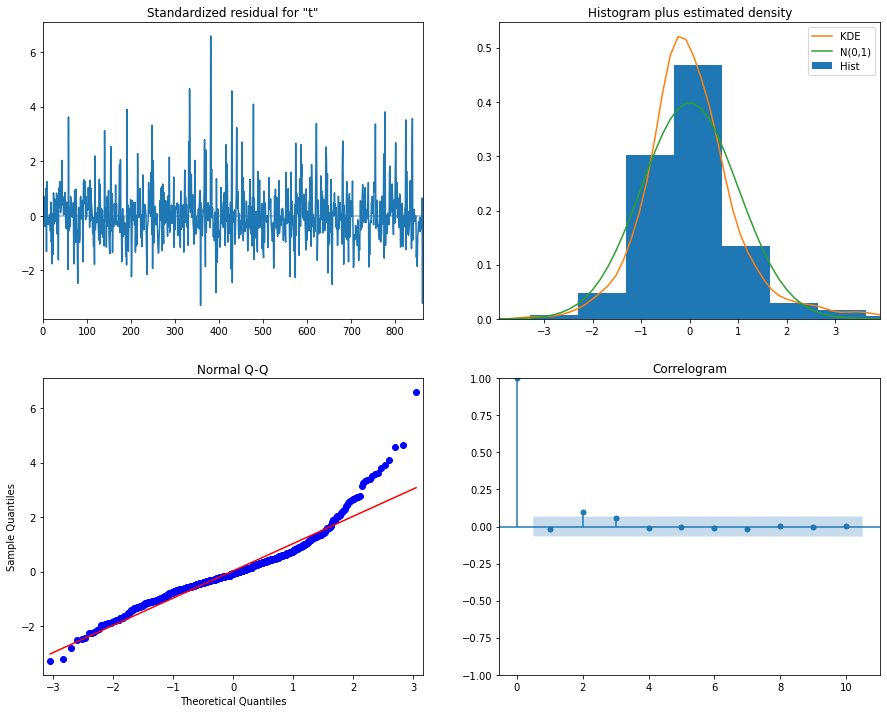

In [53]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [54]:
pred = results.get_prediction(start=pd.to_datetime('2018-05-15'), dynamic=False)
pred_ci = pred.conf_int()

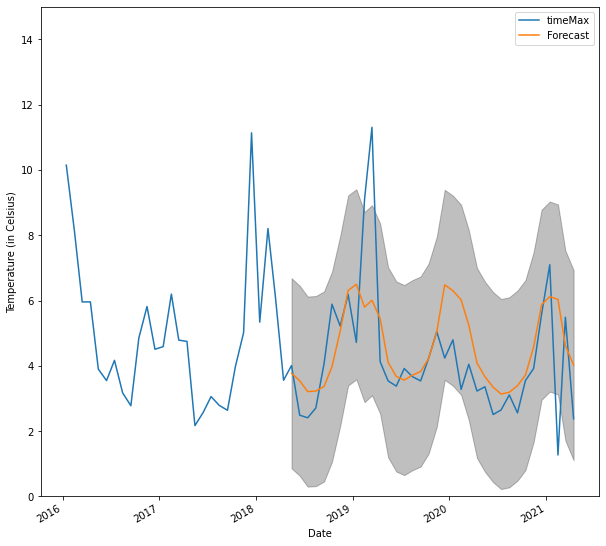

In [57]:
ax = dfMax['2016':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([-0,15])
plt.legend()
plt.show()

In [61]:
y_forecasted = pred.predicted_mean
y_truth = dfMax['2018-05-15':]
print(y_forecasted.shape)
print(y_truth.shape)
# Compute the mean square error
mse = MSE(y_truth, y_forecasted, squared=True)
print('The Mean Squared Error of our forecasts is {} (degrees)'.format(round(mse, 2)))

(36,)
(36, 1)
The Mean Squared Error of our forecasts is 2.7 (degrees)


------------------------------------------------------------------------------------------------------------SECOND MODEL---------------------------------------------------------------------------------------------------------------------

I have manually divided the dataset into Training and Test (last year). Since it was important to keep the index the Training is just the dataset with Nan values for the last 12 months. Is it a reasonable approach? 

In [105]:
train = dfMax.copy()
test = dfMax[(len(dfMax)-12):]
train[-12:] = float("NAN")

In [106]:
train

,timeMax
time,
1947-01-15,4.33
1947-02-15,3.51
1947-03-15,4.59
1947-04-15,1.61
1947-05-15,2.46
...,...
2020-12-15,NaN
2021-01-15,NaN
2021-02-15,NaN


In [107]:
test

,timeMax
time,
2020-05-15,3.36
2020-06-15,2.51
2020-07-15,2.65
2020-08-15,3.11
2020-09-15,2.56
2020-10-15,3.55
2020-11-15,3.92
2020-12-15,5.58
2021-01-15,7.10


In [108]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [109]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages
metric_aic_dict = dict()
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            metric_aic_dict.update({(param,param_seasonal):results.aic})
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:4748.443828841142
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:4248.5989831734605
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:3755.037977646083
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:3191.495513987505
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:3684.006632808966
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:3224.438927018593
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:3392.5966191404395
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3197.982405206752
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:4232.252070689252
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3980.650510227666
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:3740.2014323403464
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:3164.9277051402164
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:3654.1283349785626
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:3200.546524239993
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:3367.3412383280383
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:3170.42388290614
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:3713.1678316787174
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:3663

In [110]:
{k: v for k, v in sorted(metric_aic_dict.items(),key=lambda x:x[1])}

{((1, 1, 1), (0, 1, 1, 12)): 3131.7648817455993,
 ((1, 0, 1), (0, 1, 1, 12)): 3134.6192361567328,
 ((1, 0, 1), (1, 1, 1, 12)): 3141.8749187992953,
 ((1, 1, 1), (1, 1, 1, 12)): 3143.9292574191645,
 ((0, 1, 1), (0, 1, 1, 12)): 3145.206360025382,
 ((0, 1, 1), (1, 1, 1, 12)): 3155.981117738642,
 ((1, 0, 0), (0, 1, 1, 12)): 3160.5410577781568,
 ((0, 0, 1), (0, 1, 1, 12)): 3164.9277051402164,
 ((1, 0, 0), (1, 1, 1, 12)): 3167.6190521146773,
 ((0, 0, 1), (1, 1, 1, 12)): 3170.42388290614,
 ((1, 0, 1), (1, 0, 1, 12)): 3175.858447733506,
 ((1, 1, 1), (1, 0, 1, 12)): 3188.6567012769547,
 ((0, 0, 0), (0, 1, 1, 12)): 3191.495513987505,
 ((1, 0, 0), (1, 0, 1, 12)): 3196.6498673356887,
 ((0, 0, 0), (1, 1, 1, 12)): 3197.982405206752,
 ((0, 0, 1), (1, 0, 1, 12)): 3200.546524239993,
 ((0, 1, 1), (1, 0, 1, 12)): 3200.551495444729,
 ((0, 0, 0), (1, 0, 1, 12)): 3224.438927018593,
 ((1, 0, 1), (1, 1, 0, 12)): 3344.8598238244645,
 ((1, 1, 1), (1, 0, 0, 12)): 3346.784840515891,
 ((1, 1, 0), (0, 1, 1, 12)): 33

In [111]:
#{((1, 1, 1), (0, 1, 1, 12)): 3131.7648817455993,
# Fit the SARIMAX model using optimal parameters
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1445      0.031      4.609      0.000       0.083       0.206
ma.L1         -0.9659      0.011    -84.256      0.000      -0.988      -0.943
ma.S.L12      -0.9701      0.014    -67.214      0.000      -0.998      -0.942
sigma2         2.2063      0.061     36.364      0.000       2.087       2.325


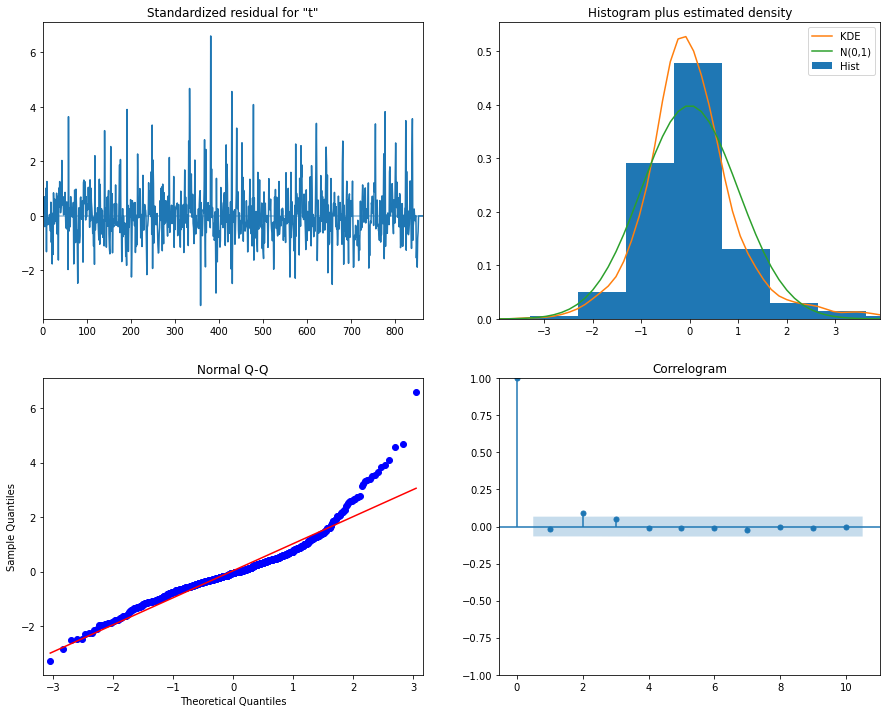

In [112]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

1 year prediction: original data vs predictions figsize=(20, 15)

In [113]:
pred = results.get_prediction(start=pd.to_datetime('2020-05-15'), dynamic=False)
pred_ci = pred.conf_int()

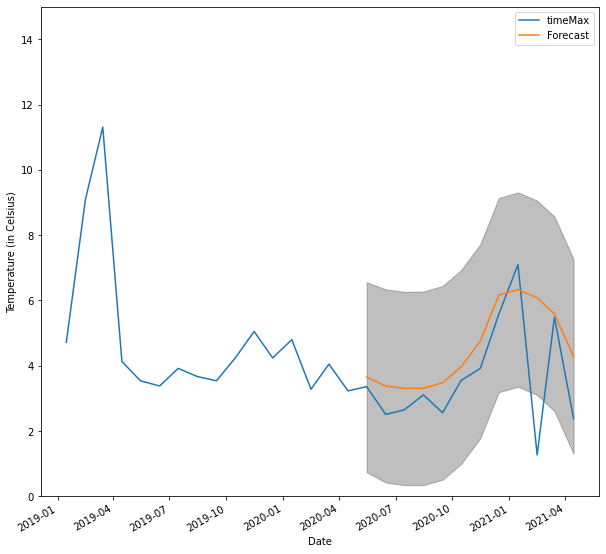

In [119]:
ax = dfMax['2019':].plot(label='observed', figsize=(10, 10))
pred.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([-0,15])
plt.legend()
plt.show()

In [120]:
pred = results.get_prediction(start=pd.to_datetime('2020-05-15'), dynamic=False)
pred_ci = pred.predicted_mean
mse = MSE(test, pred_ci, squared=True)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 2.56


------------------------------------------------------------------------------------------------------------THIRD MODEL---------------------------------------------------------------------------------------------------------------------

Prediction with another code for the model- Here it's easy to change how many years to predict. With the previous one I don't know if inputing more than 1 year of Nan it's cool. here no Nan...
Maybe it's a cleaner model and code..
here trying 12 months test set but it's easy to change.

In [28]:
892-12

880

In [29]:
train1 = dfMax[:880]
test1 = dfMax[880:]

In [30]:
smodel = pm.auto_arima(train1, start_p=1, start_q=1,
                         #test2='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.62 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=3760.538, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=3415.697, Time=0.55 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=3758.553, Time=0.07 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=3747.329, Time=0.18 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=3327.001, Time=1.57 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=8.56 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=3349.190, Time=1.37 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=3319.468, Time=1.65 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=3405.566, Time=0.64 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=9.58 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.51 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=3316.5

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  880
Model:             SARIMAX(1, 0, 1)x(2, 1, [], 12)   Log Likelihood               -1651.474
Date:                             Thu, 27 May 2021   AIC                           3312.949
Time:                                     23:29:06   BIC                           3336.780
Sample:                                          0   HQIC                          3322.068
                                             - 880                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7357      0.105      7.031      0.000       0.531       0.941
ma.L1         -0.5885      0.117     -5.013      0.000      -0.819      -0.358
ar.S.L12      -0.7554      0.023    -33.203      0.000      -0.800      -0.711
ar.S.L24      -0.3212      0.024    -13.622      0.000      -0.367      -0.275
sigma2         2.6087      0.075     34.613      0.000       2.461       2.756
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               576.12
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                             0.54
Prob(H) (two-sided):                  0.08   Kurtosis:                         6.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

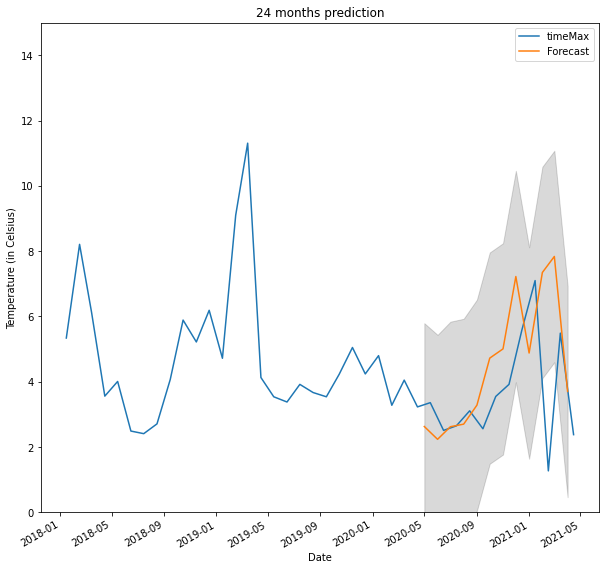

In [31]:
# Forecast
n_periods = 12
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(train1.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
ax = dfMax['2018':].plot(label='observed', figsize=(10, 10))
fitted_series.plot(ax=ax, label='Forecast')

ax.fill_between(lower_series.index,
                lower_series,
               upper_series, color='k', alpha=.15)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([-0,15])
plt.legend()
plt.title("24 months prediction")
plt.show()

In [32]:
mse = MSE(test1, fitted_series, squared=True)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 4.64


Thank for watching, this is madness = follie https://www.youtube.com/watch?v=0vF0xd9h63Y&feature=youtu.be